In [48]:
%load_ext autoreload
%autoreload 2

from msr.deeplearning.datasets import PtbXLDataset
from msr.deeplearning.datamodules import PtbXLDataModule, BaseDataModule
from msr.data.raw.ptbxl import FS

TARGET = "diagnostic_class"
BASE_PARAMS = dict(fs=FS, target=TARGET)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
rep_type = "whole_signal_features"
dm = PtbXLDataModule(rep_type, **BASE_PARAMS)
dm.setup()

In [64]:
from sklearn.ensemble import RandomForestClassifier
from msr.evaluation.metrics import get_classification_metrics
from msr.evaluation.visualisations import plot_confusion_matrix, plot_feature_importance

In [95]:
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import abstractmethod
from typing import Protocol
import matplotlib.pyplot as plt

class BasePredictor(Protocol):
    def fit(self, X, y, sample_weight=None): ...
    def predict(self, X): ...
    def score(self, X, y, sample_weight=None): ...
    def set_params(self, **params): ...


def get_regression_metrics(y_true, y_pred):
    pass
    
    
class MLTrainer:
    def __init__(self, model: BasePredictor, is_classifier: bool):
        self.is_classifier = is_classifier
        self.model = model
        self.metrics_fn = get_classification_metrics if self.is_classifier else get_regression_metrics
        
    def fit(self, datamodule: BaseDataModule):
        self.model.fit(
            X=datamodule.train.data.numpy(),
            y=datamodule.train.targets
        )

    def validate(self, datamodule: BaseDataModule, predict_proba: bool = True):
        val_data = datamodule.val.data.numpy()
        if predict_proba:
            return self.model.predict_proba(val_data)
        return self.model.predict(val_data)
        
    def test(self, datamodule: BaseDataModule, predict_proba: bool = True):
        test_data = datamodule.test.data.numpy()
        if predict_proba:
            return self.model.predict_proba(test_data)
        return self.model.predict(test_data)
    
    def evaluate(self, datamodule: BaseDataModule, plot=False):
        y_pred_val = self.validate(datamodule, predict_proba=self.is_classifier)
        y_pred_test = self.test(datamodule, predict_proba=self.is_classifier)
        y_values = {
            'val': (datamodule.val.targets, y_pred_val),
            'test': (datamodule.test.targets, y_pred_test),
        }
        val_metrics = self.metrics_fn(*y_values['val'])
        test_metrics = self.metrics_fn(*y_values['test'])    
        
        print(val_metrics)
        print(test_metrics)
        
        if plot:
            if self.is_classifier:
                fig, axes = plt.subplots(1, 2, figsize=(16, 6))
                for ax, (split, (y_true, y_pred)) in zip(axes, y_values.items()):
                    plot_confusion_matrix(y_true, y_pred.argmax(axis=1), class_names=datamodule.class_names, ax=ax)
                    ax.set_title(split)
                    
                    
def MLClassifierTrainer(MLTrainer):
    pass
    # TODO
    
def MLRegressorTrainer(MLTrainer):
    pass
    # TODO

In [98]:
model = RandomForestClassifier(n_estimators=20)
ml_trainer = MLTrainer(model, is_classifier=True)
ml_trainer.fit(dm)

{'fscore': 0.5697110009078937, 'acc': 0.7375152253349574, 'auc': 0.8733187996238071}
{'fscore': 0.571991106548561, 'acc': 0.7312348668280871, 'auc': 0.8637731407047589}


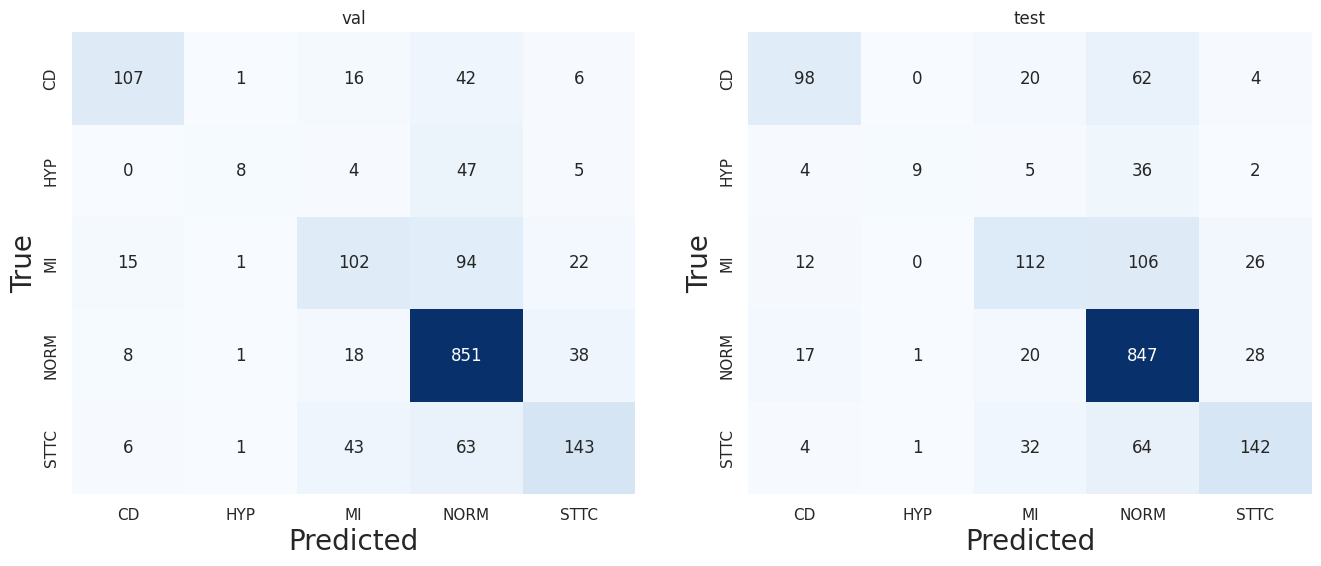

In [99]:
ml_trainer.evaluate(dm, plot=True)